## ***Plotting Spectrogram and Waveform of Audio Sample***



#### ***Recording Audio***

In [2]:
!pip install ffmpeg-python

In [3]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [4]:
audio, sr = get_audio()

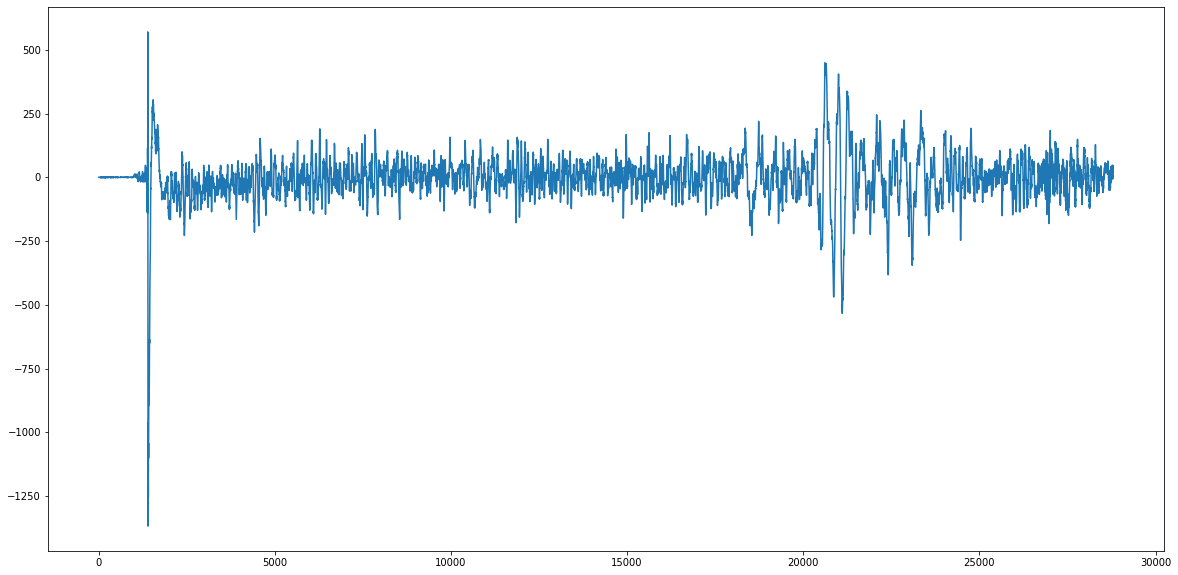

In [5]:
# Plotting the waveform

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

#### ***Playing Audio***

In [8]:
from google.colab import drive
drive.mount('/content/drive')

audio_path = "/content/drive/My Drive/Dataset/Actor_01/03-01-01-01-01-01-01.wav"

y, sr = librosa.load(audio_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import IPython.display as ipd
ipd.Audio(audio_path)

#### ***Waveform of the Audio***

Text(0.5, 0, 'Time (Samples)')

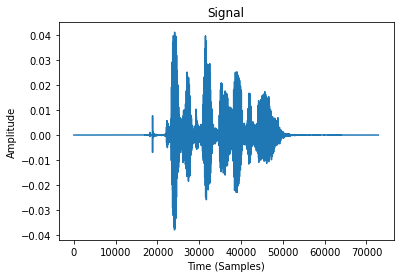

In [11]:
plt.plot(y)
plt.title("Signal")
plt.ylabel("Amplitude")
plt.xlabel("Time (Samples)")

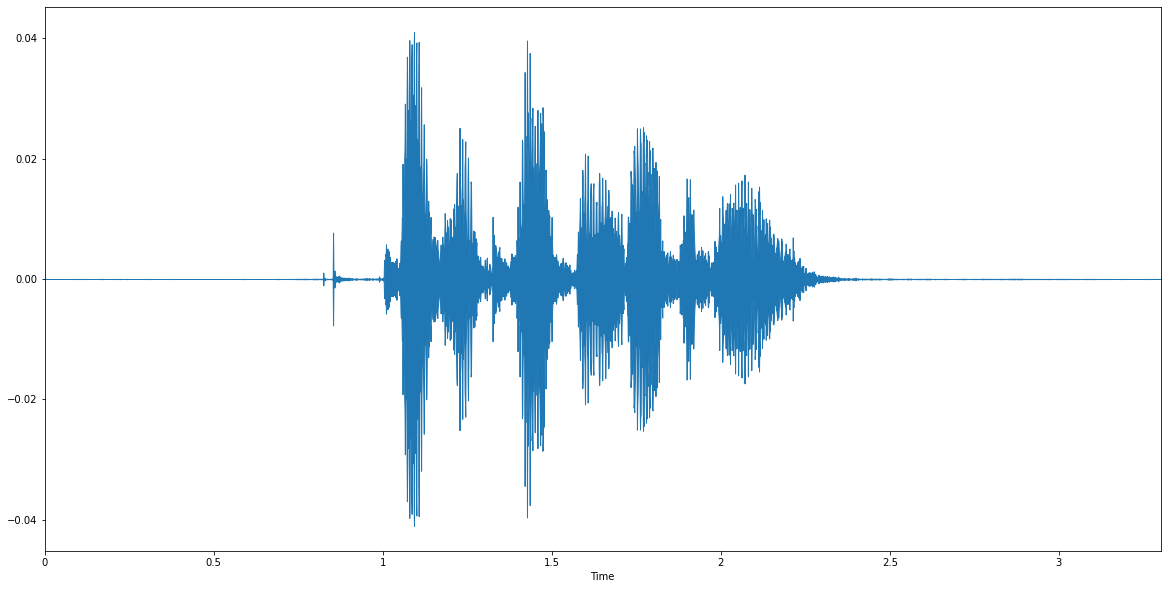

In [12]:
%matplotlib inline
import sklearn

plt.figure(figsize=(20, 10))
librosa.display.waveplot(y, sr=sr)

#### ***Fourier Transform***

Text(0, 0.5, 'Amplitude')

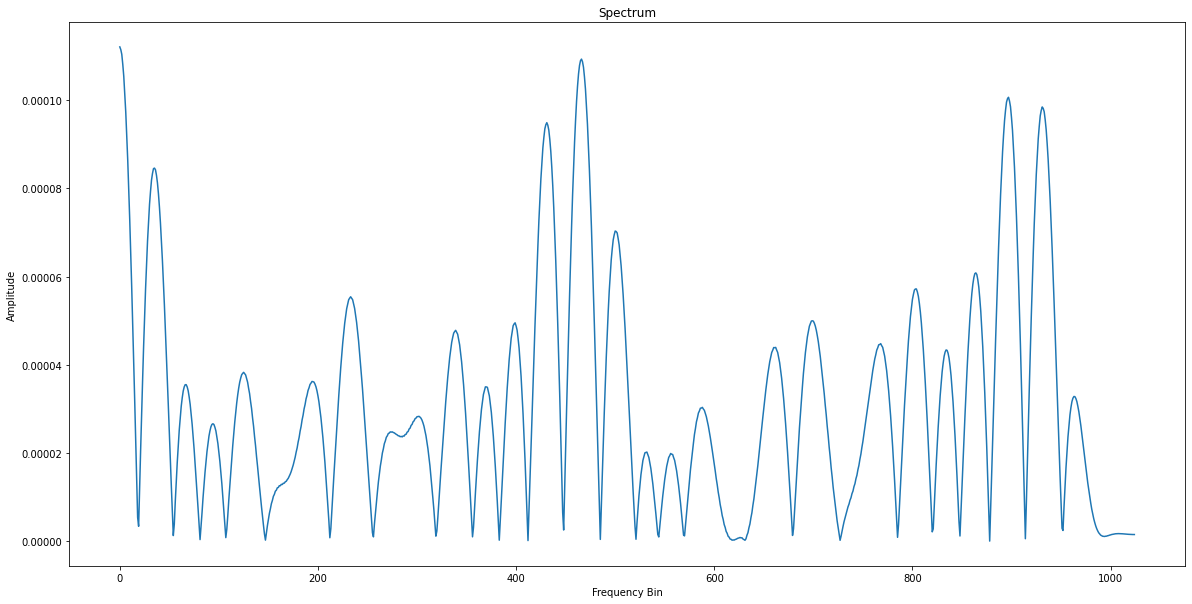

In [13]:
import numpy as np

n_fft = 2048
ft = np.abs(librosa.stft(y[:n_fft], hop_length = n_fft + 1))

plt.figure(figsize=(20, 10))
plt.plot(ft)
plt.title("Spectrum")
plt.xlabel("Frequency Bin")
plt.ylabel("Amplitude")

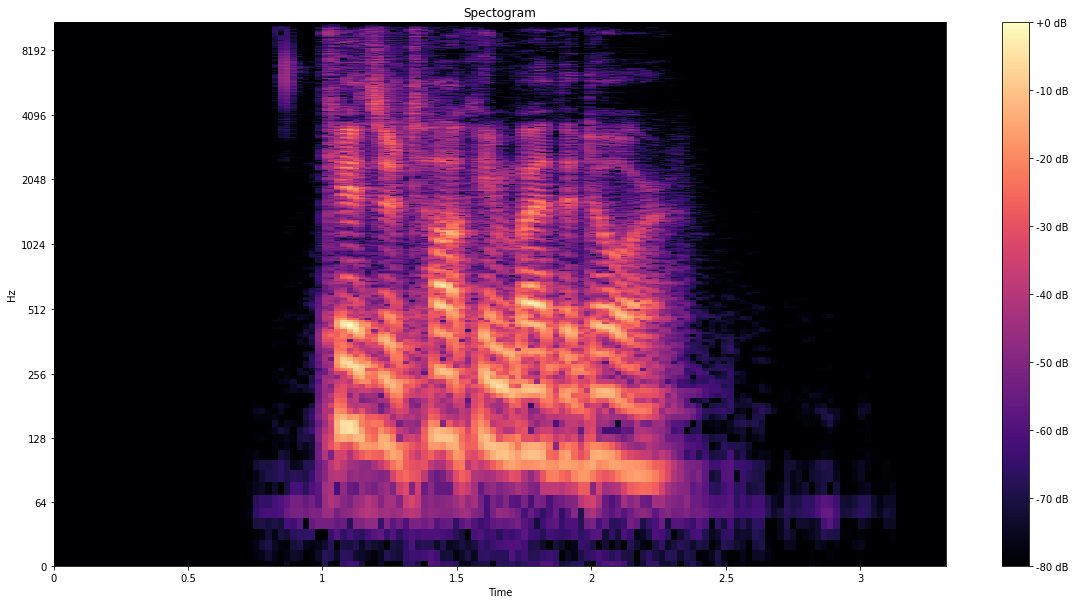

In [14]:
spec = np.abs(librosa.stft(y, hop_length = 512))
spec = librosa.amplitude_to_db(spec, ref = np.max)

plt.figure(figsize=(20, 10))
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format = '%+2.0f dB');
plt.title("Spectogram");

#### ***Mel Spectogram***

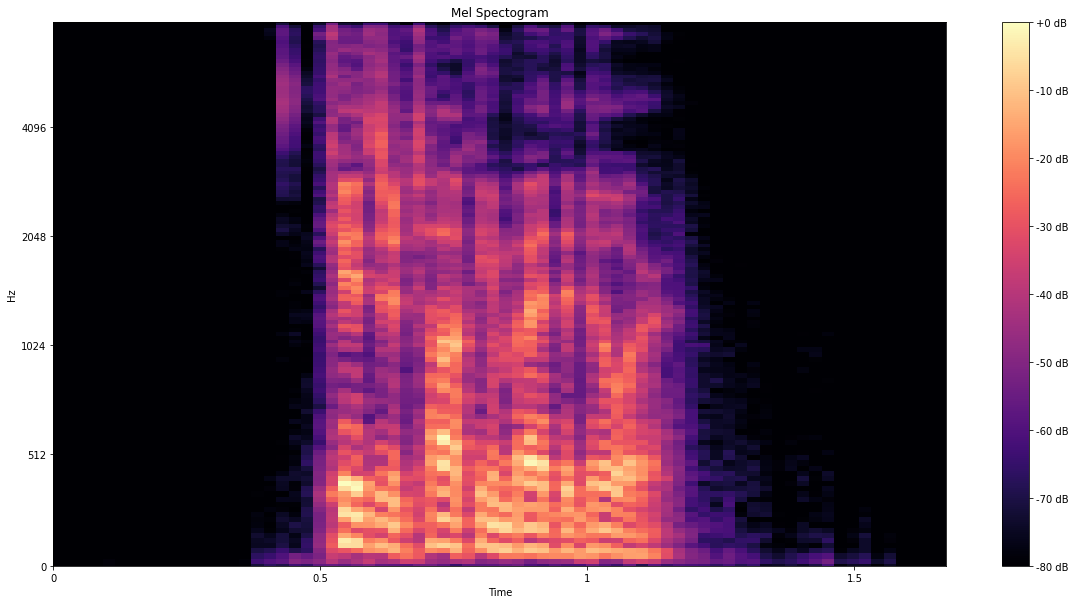

In [15]:
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 1024)
mel_spec = librosa.power_to_db(mel_spec, ref = np.max)

plt.figure(figsize=(20, 10))
librosa.display.specshow(mel_spec, fmax=8000, x_axis='time', y_axis='mel');
plt.colorbar(format = '%+2.0f dB');
plt.title("Mel Spectogram");